In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE

device(type='cuda')

In [3]:
EPOCHS = 20
BATCH_SIZE = 64

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
# trainset = datasets.MNIST{
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
# testset = 
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw




Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw




Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw




Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
train_loader = data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE
)
test_loader = data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE
)

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

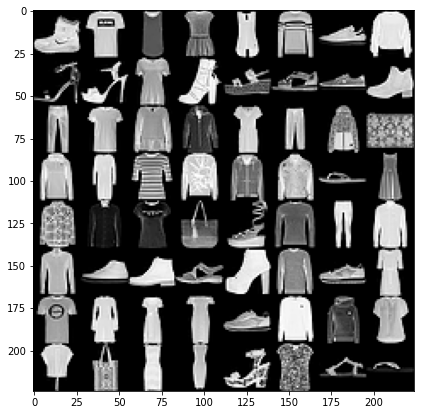

In [8]:
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [9]:
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5])


In [10]:
print(trainset.classes)
CLASSES = dict()
for i in range(10) :
    CLASSES[i] = trainset.classes[i]
print(CLASSES)


for i, label in enumerate(labels):
    index = label.item()
    print("{:12}".format(CLASSES[index]), end=' ')
    if i % 8 == 7:
        print()

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
Ankle boot   T-shirt/top  T-shirt/top  Dress        T-shirt/top  Pullover     Sneaker      Pullover     
Sandal       Sandal       T-shirt/top  Ankle boot   Sandal       Sandal       Sneaker      Ankle boot   
Trouser      T-shirt/top  Shirt        Coat         Dress        Trouser      Coat         Bag          
Coat         Dress        T-shirt/top  Pullover     Coat         Coat         Sandal       Dress        
Shirt        Shirt        T-shirt/top  Bag          Sandal       Pullover     Trouser      Shirt        
Shirt        Sneaker      Ankle boot   Sandal       Ankle boot   Pullover     Sneaker      Dress        
T-shirt/top  Dress        Dress        Dress        Sneaker      Pullover     Pullover     Shirt        
Shirt        Bag     

(28, 28)


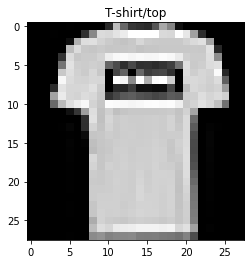

In [11]:
idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [13]:
model        = Net().to(DEVICE)
optimizer    = optim.SGD(model.parameters(), lr=0.01)

from torchsummary import summary
summary(model, (64, 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.00
Params size (MB): 0.90
Estimated Total Size (MB): 1.09
----------------------------------------------------------------


In [14]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        # loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [15]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.max(dim=1)[1]  # (max value, argmax) (batch * 10)
            # pred => [5, 7, 0, 1, 9, ..]
            correct += pred.eq(target).sum().item()  # [True, False, True, ...]

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.8364, Accuracy: 68.78%
[2] Test Loss: 0.6606, Accuracy: 77.00%
[3] Test Loss: 0.5850, Accuracy: 79.81%
[4] Test Loss: 0.5487, Accuracy: 80.62%
[5] Test Loss: 0.5272, Accuracy: 81.01%
[6] Test Loss: 0.5116, Accuracy: 81.41%
[7] Test Loss: 0.4986, Accuracy: 82.00%
[8] Test Loss: 0.4885, Accuracy: 82.26%
[9] Test Loss: 0.4798, Accuracy: 82.67%
[10] Test Loss: 0.4710, Accuracy: 83.03%
[11] Test Loss: 0.4640, Accuracy: 83.25%
[12] Test Loss: 0.4574, Accuracy: 83.53%
[13] Test Loss: 0.4499, Accuracy: 83.79%
[14] Test Loss: 0.4434, Accuracy: 84.14%
[15] Test Loss: 0.4368, Accuracy: 84.36%
[16] Test Loss: 0.4306, Accuracy: 84.63%
[17] Test Loss: 0.4246, Accuracy: 84.91%
[18] Test Loss: 0.4194, Accuracy: 85.04%
[19] Test Loss: 0.4142, Accuracy: 85.19%
[20] Test Loss: 0.4101, Accuracy: 85.27%


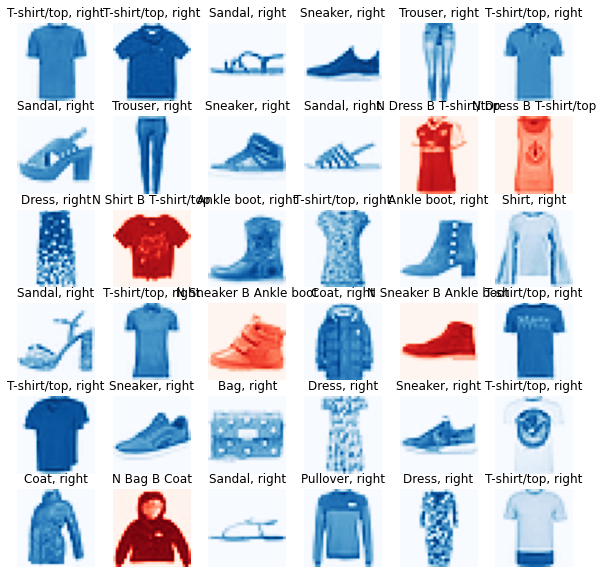

In [17]:
columns = 6
rows = 6
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(testset))
    input_img = testset[data_idx][0].unsqueeze(dim=0).to(DEVICE) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[testset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = testset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 